# **Задание 1 Анализ отдельной числовой колонки**

Загружаем необходимые библиотеки

In [160]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import VectorAssembler


Создаем Spark Session

In [161]:
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

Считываем файл

In [162]:
df = spark.read.csv('/content/1.csv', header=True, inferSchema=True)

Выполняем преобразование к числовому типу колонки feature_1

In [163]:
df = df.withColumn("feature_1", df["feature_1"].cast("float"))

Выводим статистические характеристики колонки feature_1

In [164]:
stats = df.describe("feature_1")
stats.show()  # Показываем статистику: count, mean, stddev, min, max

+-------+------------------+
|summary|         feature_1|
+-------+------------------+
|  count|               907|
|   mean| 53.97198656244078|
| stddev|19.434352870887004|
|    min|          19.28857|
|    max|          87.08522|
+-------+------------------+



Рассчитаем дополнительно коэффициенты асимметрии и эксцесса. Используем агрегатные функции.

In [165]:
mean_val = df.select(F.mean("feature_1")).first()[0]  # Среднее значение
stddev_val = df.select(F.stddev("feature_1")).first()[0]  # Стандартное отклонение
skewness = df.select(F.avg((df["feature_1"] - mean_val)**3).alias("skewness")).first()[0] / (stddev_val ** 3)
kurtosis = df.select(F.avg((df["feature_1"] - mean_val)**4).alias("kurtosis")).first()[0] / (stddev_val ** 4) - 3

Записываем полученные данные в файл JSON

In [166]:
data = {
    "Статистические характеристики": stats.collect(),  # Преобразуем в список
    "Коэффициенты асимметрии и эксцесса": {
        "Асимметрия": skewness,
        "Эксцесс": kurtosis
    }
}

with open('path_to_your_file.json', 'w') as outfile:
    json.dump(data, outfile)  # Сохраняем данные в JSON файл

# **Задание 2 Анализ отдельной категориальной колонки**

Библиотки уже загружены. Создаем Spark Session.

In [167]:
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

Считываем файл.

In [168]:
df = spark.read.csv('/content/2.csv', header=True, inferSchema=True)

Указываем колонку для группировки,выполняем группировку по указанной колонке категориальных данных, а также приведенные агрегации (частота, среднее, максимальное, минимальное, процент от общего числа).

In [169]:
category_column = 'category'
value_column = 'price'

In [170]:
aggregated_df = df.groupBy(category_column).agg(
    F.count("*").alias("frequency"),  # Частота
    F.avg(value_column).alias("average"),  # Среднее
    F.max(value_column).alias("max"),  # Максимальное значение
    F.min(value_column).alias("min")  # Минимальное значение
)

Вычисляем процент от общего числа записей и полученный результат

In [171]:
total_count = df.count()
aggregated_df = aggregated_df.withColumn("percentage", (F.col("frequency") / total_count) * 100)
aggregated_df.show()

+-----------------+---------+-----------------+----+---+------------------+
|         category|frequency|          average| max|min|        percentage|
+-----------------+---------+-----------------+----+---+------------------+
|             Мясо|      188|5020.686170212766|9969|144|14.461538461538462|
|Молочные продукты|      178|5098.651685393258|9969|157|13.692307692307693|
|            Овощи|      199|4961.522613065326|9789|172|15.307692307692308|
|           Фрукты|      190|           5532.3|9980|155|14.615384615384617|
|  Товары для дома|      177|5256.960451977401|9983|120|13.615384615384615|
|          Напитки|      189|5374.195767195767|9984|185|14.538461538461538|
|          Бакалея|      179|4907.659217877095|9914|121| 13.76923076923077|
+-----------------+---------+-----------------+----+---+------------------+



Построим круговую диаграмму, отражающую общее распределение по значениям категориальной колонки.

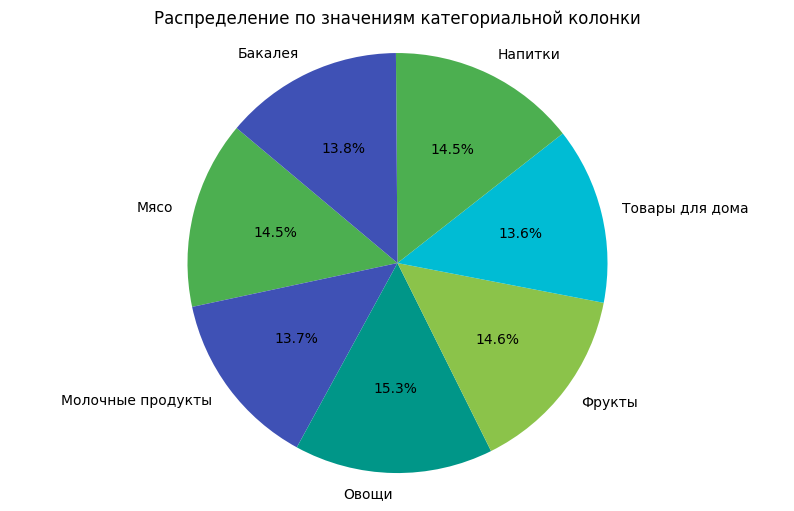

In [172]:
pandas_df = aggregated_df.toPandas()

colors = ['#4CAF50', '#3F51B5', '#009688', '#8BC34A', '#00BCD4']

plt.figure(figsize=(10, 6))
plt.pie(pandas_df['frequency'], labels=pandas_df[category_column], autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')
plt.title('Распределение по значениям категориальной колонки')
plt.show()

Записываем полученные данные в файл JSON

In [173]:
output_data = pandas_df.to_dict(orient='records')
with open('aggregated_data.json', 'w') as outfile:
    json.dump(output_data, outfile)

In [174]:
spark.stop()

# **Задание 3. Анализ пары числовых колонок**

In [175]:
spark = SparkSession.builder \
    .appName("Correlation Analysis") \
    .getOrCreate()

Считываем файл и создаем DataFrame.

In [176]:
file_path = '/content/3.csv'
spark_df = spark.read.csv(file_path, header=True, inferSchema=True)

Подготовим данные для дальнейшей работы.

In [177]:
pandas_df = spark_df.toPandas()
pandas_df.dropna(inplace=True) #Проверяем на наличие NaN и удаляем строки с NaN

Рассчитаем и выведем матрицу корреляций.

In [178]:
correlation_matrix = pandas_df.corr()
print("Матрица корреляций:")
print(correlation_matrix)

Матрица корреляций:
           feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
feature_1   1.000000   0.035120   0.008856  -0.017755   0.014043  -0.041957   
feature_2   0.035120   1.000000   0.018718  -0.011508  -0.003477   0.024251   
feature_3   0.008856   0.018718   1.000000   0.022717   0.008825  -0.001953   
feature_4  -0.017755  -0.011508   0.022717   1.000000  -0.014410  -0.044188   
feature_5   0.014043  -0.003477   0.008825  -0.014410   1.000000   0.003298   
feature_6  -0.041957   0.024251  -0.001953  -0.044188   0.003298   1.000000   
feature_7   0.008319  -0.038921  -0.007811  -0.044397   0.025704   0.008835   
feature_8   0.008961  -0.007280  -0.026287   0.003464  -0.054425   0.017074   
id          0.002977   0.022545   0.020974  -0.005804   0.026676   0.002630   
target      0.031635  -0.006531   0.036130  -0.021407   0.037675   0.006373   

           feature_7  feature_8        id    target  
feature_1   0.008319   0.008961  0.002977  0.031635  
fe

Построим диаграмму типа Scatter для визуализации корреляционных связей.

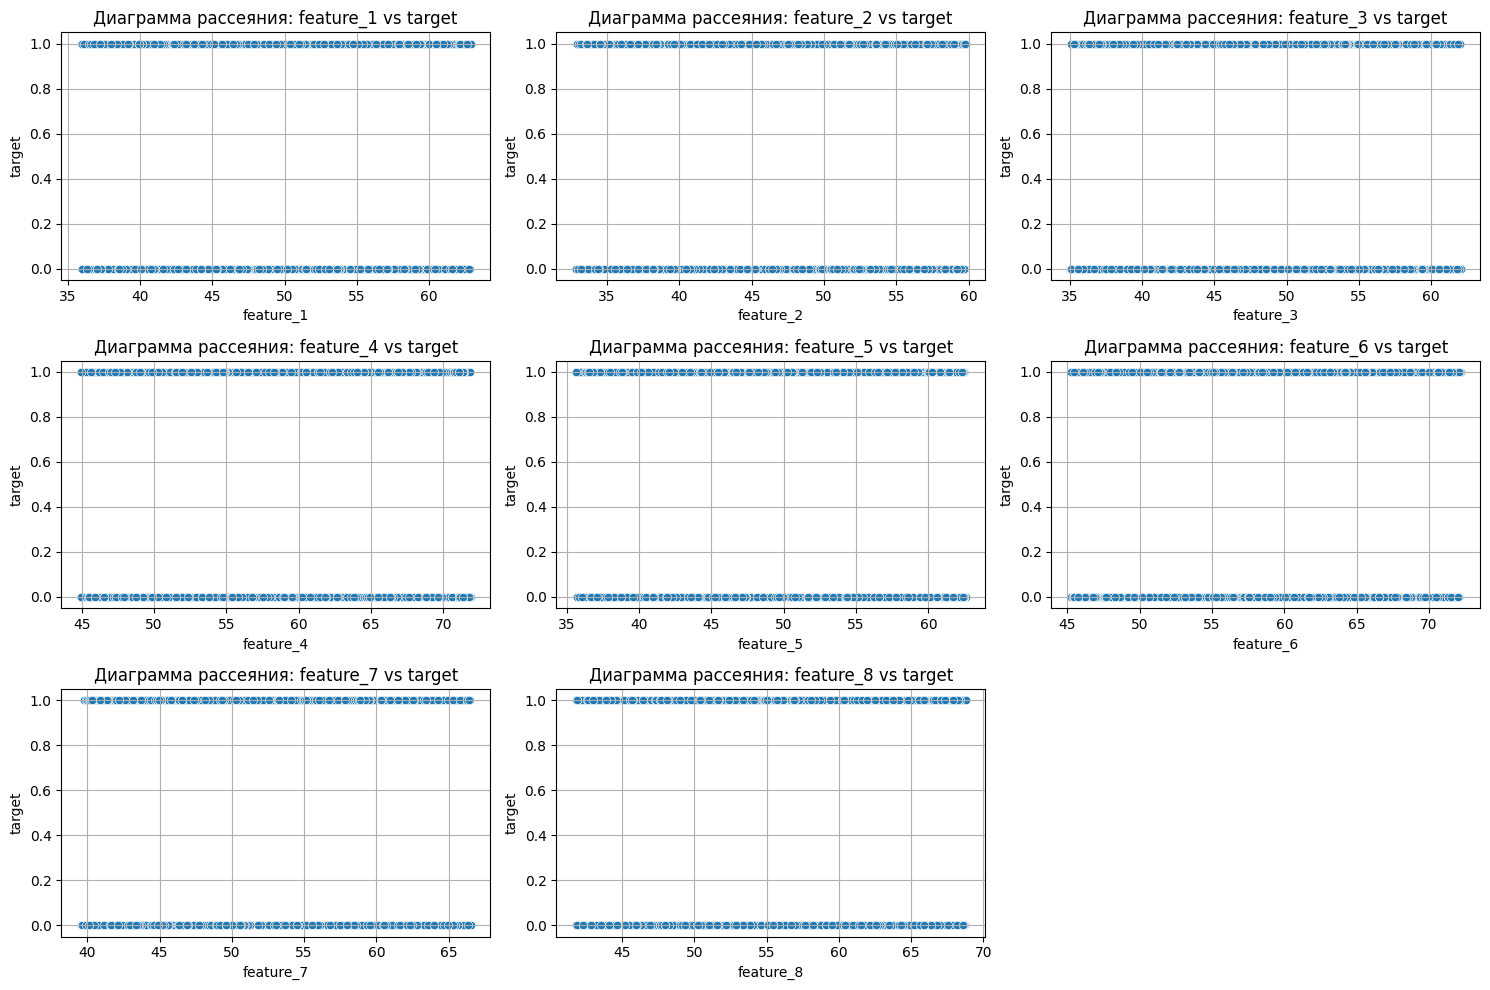

In [179]:
# Выберем признаки для визуализации
features = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']

# Построим диаграммы рассеяния
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=pandas_df, x=feature, y='target')
    plt.title(f'Диаграмма рассеяния: {feature} vs target')
    plt.xlabel(feature)
    plt.ylabel('target')
    plt.grid()

plt.tight_layout()
plt.show()

Корреляция с целевой переменной (target):либо на отрицательную, либо на слабо положительную связь.
Корреляция между признаками: между большинством признаков тоже очень низкие, что говорит о том, что они не сильно связаны друг с другом.
Например, feature_1 и feature_2 имеют корреляцию 0.0351, что указывает на слабую связь.
feature_7 и feature_8 имеют корреляцию -0.0318, что также указывает на слабую отрицательную связь.

Запишем данные в файл JSON

In [180]:
data_to_save = {
    "correlation_matrix": correlation_matrix.to_dict(),
    "features": features
}


with open('data_visualization.json', 'w') as json_file:
    json.dump(data_to_save, json_file)


# **Задание 4. Анализ пары категориальных колонок**

In [181]:
spark = SparkSession.builder \
    .appName("Chi-Squared Test") \
    .getOrCreate()

Считываем файл

In [182]:
file_path = "/content/4.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

Посмотрим структуру DataFrame - первые 5 строк

In [183]:
df.show(5)

+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+---+------+
|        feature_1|         feature_2|         feature_3|         feature_4|        feature_5|        feature_6|         feature_7|         feature_8|        feature_9|        feature_10|       feature_11|       feature_12|        feature_13|        feature_14|        feature_15| id|target|
+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+---+------+
|55.76663747172394| 65.03237844111922|57.157691500860295| 73.26246666104147|68.27268470559622|58.99099370285824| 72.78037610

Подготовим исходный набор данных для расчета критерия согласия Пирсона (Pearson’s Chi-squared test)

In [184]:
df = df.withColumn('target', F.col('target').cast('int'))
category_columns = ['feature_1', 'target']
df_one_hot = df.groupBy(category_columns).count() # Преобразуем данные для ChiSquareTes
chi_square_data = df_one_hot.groupBy('feature_1').pivot('target').sum('count').fillna(0) #Преобразуем в формат, подходящий для ChiSquareTest
chi_square_data.show()

+------------------+---+---+
|         feature_1|  0|  1|
+------------------+---+---+
| 63.58821098165589|  0|  1|
| 58.88140361364465|  0|  1|
| 81.69177044938826|  0|  1|
|48.892280276262255|  0|  1|
| 76.06772745798412|  0|  1|
| 69.09588357453674|  1|  0|
|  85.1333738493725|  1|  0|
| 58.60107698027556|  0|  1|
| 80.68221986708676|  0|  1|
|  35.2633486811397|  1|  0|
| 41.81248375227206|  0|  1|
| 62.11837178100009|  1|  0|
| 80.81757989915621|  0|  1|
| 84.36132679347473|  0|  1|
| 37.42697237493746|  0|  1|
| 76.35524629723487|  0|  1|
| 63.41566322604771|  1|  0|
|56.280301883043784|  0|  1|
|37.051197503215086|  1|  0|
| 69.00147314212728|  1|  0|
+------------------+---+---+
only showing top 20 rows



Собираем данные в векторный формат и проводим тест с извлечением результата.

In [185]:
assembler = VectorAssembler(inputCols=chi_square_data.columns[1:], outputCol='features')
chi_square_vector = assembler.transform(chi_square_data)
chi_square_test_result = ChiSquareTest.test(chi_square_vector, 'features', 'feature_1')

chi2_statistics = chi_square_test_result.statistics
pValues = chi_square_test_result.pValues
degrees_of_freedom = chi_square_test_result.degreesOfFreedom

Запиываем полученные данные в файл.

In [186]:
# 7. Запись полученных данных в файл
result_df = pd.DataFrame({
    'chi2': [chi2_statistics],
    'p-value': [pValues],
    'degrees_of_freedom': [degrees_of_freedom]
})

result_df.to_csv("chi_square_results.csv", index=False)

print("Результаты успешно сохранены в файл chi_square_results.csv")

Результаты успешно сохранены в файл chi_square_results.csv


In [187]:
# Завершение работы с Spark
spark.stop()